# Lab session 2: Language modeling

This lab covers classical and neural language models as seen in the theory lectures. 

General instructions:
- Complete the code where needed
- Provide answers to questions only in the cell where indicated
- **Do not alter the evaluation cells** (`## evaluation`) in any way as they are needed for the partly automated evaluation process

We advise you to run this notebook on Google Colab, otherwise we cannot guarantee identical versioning of the packages used in this lab (which is necessary for the automated checks). This also allows you to run your code on a GPU, which is especially relevant for the second part (Deep Learning Based Language Models). 

## **How AI can write a paper!**

We shall train our language model on a corpus of scientific articles and see if we can generate a new one!

<img src="https://media1.tenor.com/images/073dfe5d68e2490903aa51ae0ac633de/tenor.gif?itemid=3536848" alt="img" width="512px"/>



In [134]:
# import necessary packages

from __future__ import division
from __future__ import unicode_literals

import random as rand
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

In [135]:
# for reproducability
SEED = 42
np.random.seed(SEED)

## **Data exploration**

Lets download and look into the data:


In [136]:
!wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz
data = pd.read_json("./arxivData.json")
data.sample(n=5)

--2023-03-23 17:21:56--  https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz [following]
--2023-03-23 17:21:56--  https://www.dropbox.com/s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1d27ce40fd3127803fdc8f90ca.dl.dropboxusercontent.com/cd/0/get/B4wfLltNT01piBtMQ_g_MUqSpruHKfVtbmiDs5A8sE-st_U2-CG1SSHUwRRgvjSjNfuzJ-OW_LdI3KCcbdWCdkSNC-TEy55-3_15xewkgrQdXVt2KA3pIBjuPGz7VbbV98ukbq9XtutaW-2cZijxI4I3KUMXJUvDyqakw9NAHbG3EQ/file?dl=1# [following]
--2023-03-23 17:21:57--  https://uc1d27ce40fd3127803fdc8f90ca.dl.dropboxusercontent.com/cd/0/get/B4wfLltNT01piBtMQ_g_MUqSpruHKfVtbmiDs5A8sE-st_U2-CG

,author,day,id,link,month,summary,tag,title,year
857,"[{'name': 'A. N. Gorban'}, {'name': 'A. Y. Zin...",2,0809.0490v2,"[{'rel': 'related', 'href': 'http://dx.doi.org...",9,"In many physical, statistical, biological and ...","[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",Principal Graphs and Manifolds,2008
144,"[{'name': 'Behnam Neyshabur'}, {'name': 'Ryota...",27,1503.00036v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",2,"We investigate the capacity, convexity and cha...","[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",Norm-Based Capacity Control in Neural Networks,2015
22961,"[{'name': 'Maria De-Arteaga'}, {'name': 'Willi...",27,1711.09522v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",11,This is the Proceedings of NIPS 2017 Workshop ...,"[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",Proceedings of NIPS 2017 Workshop on Machine L...,2017
19448,"[{'name': 'J. Keppens'}, {'name': 'Q. Shen'}]",30,1107.0035v1,"[{'rel': 'related', 'href': 'http://dx.doi.org...",6,The predominant knowledge-based approach to au...,"[{'term': 'cs.AI', 'scheme': 'http://arxiv.org...",Compositional Model Repositories via Dynamic C...,2011
2331,"[{'name': 'Kevin T. Kelly'}, {'name': 'Conor M...",15,1203.3488v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",3,"Over the past two decades, several consistent ...","[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",Causal Conclusions that Flip Repeatedly and Th...,2012


In [137]:
# Assemble lines: concatenate title and description
lines = data.apply(lambda row: row['title'] + ' ; ' + row['summary'], axis=1).tolist()

# Sample the first 3 lines...
sorted(lines, key=len)[:3]

['Differential Contrastive Divergence ; This paper has been retracted.',
 'What Does Artificial Life Tell Us About Death? ; Short philosophical essay',
 'P=NP ; We claim to resolve the P=?NP problem via a formal argument for P=NP.']

In [138]:
# Convert lines into strings of space-separated tokens
#! pip install nltk  # install if not yet installed

from nltk.tokenize import WordPunctTokenizer
tknzr = WordPunctTokenizer()
lines = [tknzr.tokenize(sent.lower()) for sent in lines]
lines = [' '.join(sent) for sent in lines]

sorted(lines, key=len)[:3]

['differential contrastive divergence ; this paper has been retracted .',
 'what does artificial life tell us about death ? ; short philosophical essay',
 'p = np ; we claim to resolve the p =? np problem via a formal argument for p = np .']

## **N-Gram Language Model**

A language model is a probabilistic model that estimates text probability: the joint probability of all tokens $w_t$ in text $X$: $P(X) = P(w_1, \dots, w_T)$.

It can do so by following the chain rule:
$$P(w_1, \dots, w_T) = P(w_1)P(w_2 \mid w_1)\dots P(w_T \mid w_1, \dots, w_{T-1}).$$ 

The problem with such approach is that the final term $P(w_T \mid w_1, \dots, w_{T-1})$ depends on $n-1$ previous words. This probability is impractical to estimate for long texts, e.g. $T = 1000$.

One popular approximation is to assume that the next word only depends on a finite amount of previous words:

$$P(w_t \mid w_1, \dots, w_{t - 1}) = P(w_t \mid w_{t - n + 1}, \dots, w_{t - 1})$$

Such a model is called an __n-gram language model__ where n is a parameter. For example, in a 3-gram language model, each word only depends on the 2 previous words. 

$$
    P(w_1, \dots, w_n) = \prod_t P(w_t \mid w_{t - n + 1}, \dots, w_{t - 1}).
$$

You might also come across this approximation under the name of the _n-th order markov assumption_.

The first stage in building such a model is counting all word occurences given the $n-1$ previous words:

### Building the model

In [139]:
from collections import defaultdict, Counter

# special tokens: 
# - UNK represents absent tokens, 
# - EOS is a special token after the end of sequence

UNK, EOS = "_UNK_", "_EOS_"

def count_ngrams(lines, n):
    """
    Count how many times each word occurred after (n - 1) previous words
    :param lines: an iterable of strings with space-separated tokens
    :returns: a dictionary { tuple(prefix_tokens): {next_token_1: count_1, next_token_2: count_2, ...}}

    When building counts, please consider the following two edge cases
    - if prefix is shorter than (n - 1) tokens, it should be padded with UNK. For n=3,
      empty prefix: "" -> (UNK, UNK)
      short prefix: "the" -> (UNK, the)
      long prefix: "the new approach" -> (new, approach)
    - you should add a special token, EOS, at the end of each sequence
      "... with deep neural networks ." -> (..., with, deep, neural, networks, ., EOS)
      count the probability of this token just like all others.
    """
    
    counts = defaultdict(Counter)
      
    # counts[(word 1, word 2 ... word n-1)][word n] 
    #    = how many times word n occurred after (word 1 ... word n-1)
    
    for sent in lines:
        sent = sent.split() + [EOS]
        for i, word in enumerate(sent):
            ############### for student ################            
            tuple_prefix = tuple(sent[max(0, i - n + 1):i])
            if len(tuple_prefix) < n - 1:
                tuple_prefix = (UNK,) * (n - 1 - len(tuple_prefix)) + tuple_prefix
            counts[tuple_prefix][word] += 1
            ############################################
    #print(counts.values())
    return counts

In [140]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

dummy_lines = sorted(lines, key=len)[:100]
dummy_counts = count_ngrams(dummy_lines, n=3)
assert set(map(len, dummy_counts.keys())) == {2}, "please only count {n-1}-grams"
assert dummy_counts['author', '.']['_EOS_'] == 1
assert dummy_counts['p', '=']['np'] == 2
assert len(dummy_counts[('_UNK_', '_UNK_')]) == 78
assert dummy_counts['_UNK_', 'a']['note'] == 3

print('well done!')

well done!


Once we can count N-grams, we can build a probabilistic language model.
The simplest way to compute probabilities is in proporiton to counts:

$$ P(w | \textit{prefix}) = { \textit{Count}(\textit{prefix}, w) \over \sum_{w' \in \textit{Vocab}} \textit{Count}(\textit{prefix}, w') } $$

In [141]:
class NGramLanguageModel:    
    def __init__(self, lines, n):
        """ 
        Train a simple count-based language model: 
        compute probabilities P(w | prefix) given n-gram counts
        
        :param n: computes probability of next token given (n - 1) previous words
        :param lines: an iterable of strings with space-separated tokens
        """
        assert n >= 1
        self.n = n
    
        counts = count_ngrams(lines, self.n)
        self.probs = defaultdict(Counter)
        
        # compute token probabilities (self.probs), given the counts computed above
        # probs[(word1, word2)][word3] = P(word3 | word1, word2)
        ############### for student ################
        #print(counts.keys())
        for prefix, next_word in counts.items():
            for word, count in next_word.items():
                self.probs[prefix][word] = count / sum(next_word.values())



        ############################################

    def get_possible_next_tokens(self, prefix):
        """
        :param prefix: string with space-separated prefix tokens
        :returns: a dictionary {token : its probability} for all tokens with positive probabilities
        """
        prefix = prefix.split()
        prefix = prefix[max(0, len(prefix) - self.n + 1):]
        prefix = [ UNK ] * (self.n - 1 - len(prefix)) + prefix
        return self.probs[tuple(prefix)]
    
    def get_next_token_prob(self, prefix, next_token):
        """
        :param prefix: string with space-separated prefix tokens
        :param next_token: the next token to predict probability for
        :returns: P(next_token|prefix) a single number, 0 <= P <= 1
        """
        return self.get_possible_next_tokens(prefix).get(next_token, 0)

Let's test it!

In [142]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

dummy_lm = NGramLanguageModel(dummy_lines, n=3)

p_initial = dummy_lm.get_possible_next_tokens('') # '' -> ['_UNK_', '_UNK_']
assert np.allclose(p_initial['learning'], 0.02)
assert np.allclose(p_initial['a'], 0.13)
assert np.allclose(p_initial.get('meow', 0), 0)
assert np.allclose(sum(p_initial.values()), 1)

p_a = dummy_lm.get_possible_next_tokens('a') # '' -> ['_UNK_', 'a']
assert np.allclose(p_a['machine'], 0.15384615)
assert np.allclose(p_a['note'], 0.23076923)
assert np.allclose(p_a.get('the', 0), 0)
assert np.allclose(sum(p_a.values()), 1)

assert np.allclose(dummy_lm.get_possible_next_tokens('a note')['on'], 1)
assert dummy_lm.get_possible_next_tokens('a machine') == \
    dummy_lm.get_possible_next_tokens("there have always been ghosts in a machine"), \
    "your 3-gram model should only depend on 2 previous words"

print("Good job!")

Good job!


Now that you've got a working n-gram language model, let's see what sequences it can generate. But first, let's train it on the whole dataset.

In [143]:
lm = NGramLanguageModel(lines, n=3)

The process of generating sequences is... well, it's sequential. You maintain a list of tokens and iteratively add the next token by sampling from the probabilities over the vocabulary at each point in the sequence.

$ X = [] $

__forever:__
* $w_{next} \sim P(w_{next} | X)$
* $X = concat(X, w_{next})$


Instead of sampling with probabilities, one can also take the most likely token, sample from among the top-K most likely tokens, or sample with a certain *temperature*. In the latter case (temperature), one samples from

$$w_{next} \sim {P(w_{next} | X) ^ {1 / \tau} \over \sum_{w'} P(w' | X) ^ {1 / \tau}}$$

Where $\tau > 0$ is the model temperature. If $\tau << 1$, more likely tokens will be sampled with even higher probability while less likely tokens will vanish. For sampling from a given probability distribution, the function `nn.random.choice` can be used.

In [144]:
def get_next_token(lm, prefix, temperature=1.0):
    """
    return next token after prefix;
    :param temperature: samples proportionally to lm probabilities ^ (1 / temperature)
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """

    ############### for student ################
    if temperature == 0:
        return max(lm.get_possible_next_tokens(prefix), key=lm.get_possible_next_tokens(prefix).get)
    else:
        probs = lm.get_possible_next_tokens(prefix)
        probs = {k: v ** (1 / temperature) for k, v in probs.items()}
        probs = {k: v / sum(probs.values()) for k, v in probs.items()}
        token = np.random.choice(list(probs.keys()), p=list(probs.values()))    #From numpy lib
    ############################################

    return token           


In [145]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

from collections import Counter
test_freqs = Counter([get_next_token(lm, 'there have') for _ in range(10000)])
assert 250 < test_freqs['not'] < 450
assert 8500 < test_freqs['been'] < 9500
assert 1 < test_freqs['lately'] < 200
test_freqs = Counter([get_next_token(lm, 'deep', temperature=1.0) for _ in range(10000)])
assert 1500 < test_freqs['learning'] < 3000
test_freqs = Counter([get_next_token(lm, 'deep', temperature=0.0) for _ in range(10000)])
assert test_freqs['learning'] == 10000
test_freqs = Counter([get_next_token(lm, 'deep', temperature=0.5) for _ in range(10000)])
assert 8000 < test_freqs['learning'] < 9000

print("Looks nice!")

Looks nice!


Let's have fun with this model:

In [146]:
prefix = 'artificial' # <- your ideas on the start of your AI generated scientific paper :)

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break
        
print(prefix)

artificial persuasion in abstract argumentation frameworks . this work , we use a technique to solve this problem has been successful in extracting organization names in various real - world data regression problems ; to solve the problem defaults were intended to cause parameters to be adopted , where there are still subject to some state - observation model by allowing nonmonotonic inferences and show distribution - independent behaviors . we evaluate the performance of each position . over - segmentation to assign dependency relation matrix , and can solve various fault detection problems arising in random experiments . _EOS_


In [147]:
prefix = 'bridging the' # <- more of your ideas

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix, temperature=0.4)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break
        
print(prefix)

bridging the gap between the amount of data mining , and it is possible to train a deep neural networks ( cnns ) and the results of a set of labeled data for the task of learning the parameters of the proposed method is significantly faster than the original data set . we show that the proposed method . _EOS_


### Question 1 
How does the temperature parameter affect the generated samples?

**<font color=blue><<< INSERT ANSWER HERE >>></font>**
- If the temperature is equal to 0, the model choses the always the word with the highest probability, as it increases the probability distrbution becomes more unform and so adds more randomness to the choice.

### **Evaluating language models: perplexity**

Perplexity is a measure of how well your model approximates the true probability distribution behind the data. __Smaller perplexity = better model__.

To compute the perplexity on one sentence, we can use:
$$
    {\mathbb{P}}(w_1 \dots w_N) = P(w_1, \dots, w_N)^{-\frac1N} = \left( \prod_t P(w_t \mid w_{t - n}, \dots, w_{t - 1})\right)^{-\frac1N},
$$


On the corpus level, N would be equal to the __total length of all sentences__ in the corpora, and the product is taken over the probabilities of all tokens in all sentences. 

This number can quickly get too small for float32/float64 precision, so we recommend you to first compute the log-perplexity (take the log of the formula above, to transform it into a sum of log-probabilities) and then take the exponent to get the perplexity itself. 

In [148]:
def perplexity(lm, lines, min_logprob=np.log(10 ** -50.)):
    """
    :param lines: a list of strings with space-separated tokens
    :param min_logprob: if log(P(w | ...)) is smaller than min_logprob, set it equal to min_logrob
    :returns: corpora-level perplexity - a single scalar number from the formula above
    
    Note: do not forget to compute P(w_first | empty) and P(eos | full_sequence)
    
    PLEASE USE lm.get_next_token_prob and NOT lm.get_possible_next_tokens
    """

    
    N = 0  # number of tokens
    ppl = 0.0 # perplexity
    
    # https://stats.stackexchange.com/questions/129352/how-to-find-the-perplexity-of-a-corpus
    ############### for student ################
    for sent in lines:
        sent = sent.split() + [EOS]
        for i, word in enumerate(sent):
            if i == 0:
                if np.log(lm.get_next_token_prob("", word)) < min_logprob:
                    ppl += min_logprob
                else:
                    ppl += np.log(lm.get_next_token_prob("", word))
            else:
                if np.log(lm.get_next_token_prob(" ".join(sent[:i]), word)) < min_logprob:
                    ppl += min_logprob
                else:
                    ppl += np.log(lm.get_next_token_prob(" ".join(sent[:i]), word))
            N += 1
    ppl = np.exp(-ppl / N)


    ############################################
    
    return ppl

In [149]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

lm1 = NGramLanguageModel(dummy_lines, n=1)
lm3 = NGramLanguageModel(dummy_lines, n=3)
lm10 = NGramLanguageModel(dummy_lines, n=10)

ppx1 = perplexity(lm1, dummy_lines)
ppx3 = perplexity(lm3, dummy_lines)
ppx10 = perplexity(lm10, dummy_lines)
ppx_missing = perplexity(lm3, ['the jabberwock , with eyes of flame , '])

print("Perplexities: ppx1=%.3f ppx3=%.3f ppx10=%.3f" % (ppx1, ppx3, ppx10))

assert all(0 < ppx < 500 for ppx in (ppx1, ppx3, ppx10)), "perplexity should be nonnegative and reasonably small"
assert np.isfinite(ppx_missing) and ppx_missing > 10 ** 6, "missing words should have large but finite perplexity. " \
    " Make sure you use min_logprob right"
assert ppx1 > ppx3 > ppx10, "higher N-gram models should overfit and have lower ppl"

assert np.allclose([ppx1, ppx3, ppx10], (318.2132342216302, 1.5199996213739575, 1.1838145037901249))

print('Well done!')

Perplexities: ppx1=318.213 ppx3=1.520 ppx10=1.184
Well done!


<ipython-input-148-21f26381c614>:27: RuntimeWarning: divide by zero encountered in log
  if np.log(lm.get_next_token_prob(" ".join(sent[:i]), word)) < min_logprob:


Now let's measure the actual perplexity: we'll split the data into train and test and score model on test data only.

In [150]:
train_lines, test_lines = train_test_split(lines, test_size=0.25, random_state=SEED)

for n in (1, 2, 3):
    lm = NGramLanguageModel(n=n, lines=train_lines)
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx))


<ipython-input-148-21f26381c614>:27: RuntimeWarning: divide by zero encountered in log
  if np.log(lm.get_next_token_prob(" ".join(sent[:i]), word)) < min_logprob:
<ipython-input-148-21f26381c614>:22: RuntimeWarning: divide by zero encountered in log
  if np.log(lm.get_next_token_prob("", word)) < min_logprob:


N = 1, Perplexity = 1832.23136
N = 2, Perplexity = 85653987.28774
N = 3, Perplexity = 61999196259043346743296.00000


### Question 2
Do you expect increasing/decreasing perplexities for language models with longer n-grams (i.e., higher values of n)? Does this correspond with the test output you observe above? If not: can you explain this?

**<font color=blue><<< INSERT ANSWER HERE >>></font>**
- As you increase the length of the n-grams, the perplexity increases. This is in line with what you would expect, as the length of n-grams increases, the number of possibilities grows exponentially. This growth in possibilities means more combinations to chose and so the model will be less accurate in predicting the word, so the perplexity increases. 

###  LM Smoothing

The problem with our simple language model is that whenever it encounters an n-gram it has never seen before, it assigns it the probabilitiy of 0. Every time this happens, the perplexity explodes.
To battle this issue, there's a technique called __smoothing__. 

The core idea is to modify counts in a way that prevents probabilities from getting too low. The simplest algorithm here is _additive smoothing_ (aka [Lapace smoothing](https://en.wikipedia.org/wiki/Additive_smoothing)):

$$ P(w | \textit{prefix}) = \frac{\textit{Count}(\textit{prefix}, w) \color{red}{+ \delta}}{\sum_{w' \in \textit{Vocab}}(\textit{Count}(\textit{prefix}, w') \color{red}{+ \delta})} $$

If counts for a given prefix are low, additive smoothing will adjust the probabilities to a more uniform distribution, by assigning some of the original probability mass to unseen words. 

We update the `self.probs` attribute inside the constructor (`__init__`) to handle smoothing. 

In [151]:
class LaplaceLanguageModel(NGramLanguageModel): 
    def __init__(self, lines, n, delta=1.0):
        self.n = n
        counts = count_ngrams(lines, self.n) # 
        self.vocab = set(token for token_counts in counts.values() for token in token_counts) #
        self.probs = defaultdict(Counter)
        
        for prefix in counts:
            token_counts = counts[prefix]
            total_count = sum(token_counts.values()) + delta * len(self.vocab) # denominator
            for token in token_counts:
                self.probs[prefix][token] = (token_counts[token] + delta) / total_count 

    def get_possible_next_tokens(self, prefix):
        token_probs = super().get_possible_next_tokens(prefix)
        missing_prob_total = 1.0 - sum(token_probs.values())
        missing_prob = missing_prob_total / max(1, len(self.vocab) - len(token_probs))
        return {token: token_probs.get(token, missing_prob) for token in self.vocab}

    def get_next_token_prob(self, prefix, next_token):
        token_probs = super().get_possible_next_tokens(prefix)
        if next_token in token_probs:
            return token_probs[next_token]
        else:
            missing_prob_total = 1.0 - sum(token_probs.values())
            missing_prob_total = max(0, missing_prob_total) # prevent rounding errors
            return missing_prob_total / max(1, len(self.vocab) - len(token_probs))
        

In [152]:
# calculate perplexity for LaplaceLanguageModel

from sklearn.model_selection import train_test_split
train_lines, test_lines = train_test_split(lines, test_size=0.25, random_state=SEED)

for n in (1, 2, 3):
    lm = LaplaceLanguageModel(n=n, lines=train_lines)
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx))

<ipython-input-148-21f26381c614>:27: RuntimeWarning: divide by zero encountered in log
  if np.log(lm.get_next_token_prob(" ".join(sent[:i]), word)) < min_logprob:
<ipython-input-148-21f26381c614>:22: RuntimeWarning: divide by zero encountered in log
  if np.log(lm.get_next_token_prob("", word)) < min_logprob:


N = 1, Perplexity = 1838.22427
N = 2, Perplexity = 1292.02237
N = 3, Perplexity = 10499.24004


### Question 3
In a bigram language model (without smoothing), which of the following two phrases do you expect to have higher probablity? Why?
 - *and and*
 - *this paper* 

**<font color=blue><<< INSERT ANSWER HERE >>></font>**
- I will expect "this paper" to have a high probability as its a bi-gram that we expect to apear frecuently in our corpus. In contrast I expect "and and" to have a probability of 0, as this bi-gram would never apear in our corpus.

### Question 4

If we add smoothing, how would the probability relation change for the above phrases? 

**<font color=blue><<< INSERT ANSWER HERE >>></font>**
- When smoothing is applied, then "and and" would not be 0 but a value closer to it. This is a good representation, as it is a very uncommon bi-gram to encounter, however there is a little probability that this can happen. 

Train both language models (smoothing and non-smoothing version) on `dummy_lines` and report perplexity for the given phrases.

In [153]:
# lm_names = ["without smoothing", "with smoothing"]
phrases = [["and and"], ["this paper"]]
    
lmu = LaplaceLanguageModel(dummy_lines, n=2, delta = 0)
lms = LaplaceLanguageModel(dummy_lines, n=2, delta = 1)

for lm_name,lmx in [("without smoothing", lmu), ("with smoothing", lms)]:
    for phrase in phrases:
        ppl = perplexity(lmx, phrase)
        
        print("%s: phrase = '%s' --> pp = %.2E" % (lm_name, phrase, ppl))
        

without smoothing: phrase = '['and and']' --> pp = 1.00E+50
without smoothing: phrase = '['this paper']' --> pp = 2.79E+33
with smoothing: phrase = '['and and']' --> pp = 1.01E+03
with smoothing: phrase = '['this paper']' --> pp = 3.48E+02


<ipython-input-148-21f26381c614>:22: RuntimeWarning: divide by zero encountered in log
  if np.log(lm.get_next_token_prob("", word)) < min_logprob:
<ipython-input-148-21f26381c614>:27: RuntimeWarning: divide by zero encountered in log
  if np.log(lm.get_next_token_prob(" ".join(sent[:i]), word)) < min_logprob:


## **Deep Learning Based Language Models**

We've checked out statistical approaches to language models so far. Now let's go find out what deep learning has to offer. We're gonna use the same dataset as before. 


![alt text](https://vipulvaibhaw.files.wordpress.com/2019/04/saltbae_pytorch.jpg)



We are going to implement the simplest recurrent neural network (RNN) known as the Elman RNN. Its hidden state aims to encapsulate the information for all previous input elements in order to help the network to take into account *the past*. Since there is no hidden state during the first step, we feed the network with an initial state of zero values (or randomly initilized values). Next, we feed it the first token ($\textit{comedian}$) together with the hidden state of the previous step, to predict the next output ($\textit{zelensky}$). We'll repeat this procedure until the end of sequence. 

We can summarize the above explanation into a simple equation as:

$$h_t = F(x_{t}, h_{t-1}) = f(W_{x}x_t + W_{h}h_{t-1} + b),$$

where $x_{t}$ is input, $h_{t}$ is hidden state, $b$ is a bias term and $f$ is the `tanh` non-linearity.

![Elman RNN](https://drive.google.com/uc?id=1agU_KEY79JGjjgXDJrsBnf8Cg1dC901P)

**Before proceeding, please check if your Colab notebook is running on a GPU. To do this, go to "Edit", then "Notebook settings" and select "GPU" as a hardware accelerator.**

In [154]:
### If you don't have pytorch yet: install it in the current kernel first .
### Uncomment next 2 lines to do that.
# import sys
# !conda install --yes --prefix {sys.prefix} pytorch

# first import necessary packages
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

%matplotlib inline

# for reproducibility 
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.enabled = False 
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### **Tokenization**

Before implementing the neural network itself, lets prepare the data. We need special tokens:

* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [155]:
BOS, EOS = '<s>', '</s>'
text = [BOS + ' ' + line + ' ' + EOS for line in lines] # concatenate BOS and EOS to all sentences
text = [line.split() for line in text]

In [156]:
# let's print the first sentence 
print(text[0])

['<s>', 'dual', 'recurrent', 'attention', 'units', 'for', 'visual', 'question', 'answering', ';', 'we', 'propose', 'an', 'architecture', 'for', 'vqa', 'which', 'utilizes', 'recurrent', 'layers', 'to', 'generate', 'visual', 'and', 'textual', 'attention', '.', 'the', 'memory', 'characteristic', 'of', 'the', 'proposed', 'recurrent', 'attention', 'units', 'offers', 'a', 'rich', 'joint', 'embedding', 'of', 'visual', 'and', 'textual', 'features', 'and', 'enables', 'the', 'model', 'to', 'reason', 'relations', 'between', 'several', 'parts', 'of', 'the', 'image', 'and', 'question', '.', 'our', 'single', 'model', 'outperforms', 'the', 'first', 'place', 'winner', 'on', 'the', 'vqa', '1', '.', '0', 'dataset', ',', 'performs', 'within', 'margin', 'to', 'the', 'current', 'state', '-', 'of', '-', 'the', '-', 'art', 'ensemble', 'model', '.', 'we', 'also', 'experiment', 'with', 'replacing', 'attention', 'mechanisms', 'in', 'other', 'state', '-', 'of', '-', 'the', '-', 'art', 'models', 'with', 'our', 'i

Let us convert our raw text into sequences of ids. Our goal is to create a representation of the tokens which our model will be able to manipulate.

First, we create two sorted dictionaries and map each token to an id. Second, we create the target data sequences based on the input. Note that the target is the same as the input, except that it is one token ahead of the input. This way, we can later teach our model to predict the next token in the sentence. 

In [157]:
from collections import Counter

def get_data_lm(data):
    
    word_counts = Counter()
    for sent in data:
        word_counts.update(sent)

    sorted_token = sorted(word_counts, key=word_counts.get, reverse=True)
    
    # create two dictionaries to convert token to id or vice-verca
    id_to_token = {k: w for k, w in enumerate(sorted_token)}
    token_to_id = {w: k for k, w in id_to_token.items()}
    
    n_token = len(id_to_token)
    
    tokenized_text = [[token_to_id[w] for w in sent] for sent in data]
    
    # output is one token ahead
    inp_text = [sent[:-1] for sent in tokenized_text]
    out_text = [sent[1: ] for sent in tokenized_text]

    return id_to_token, token_to_id, n_token, inp_text, out_text

In [158]:
id_to_token, token_to_id, n_token, inp_text, out_text = get_data_lm(text[0:1])

print("-- raw text:", text[0:1])
print('-' * 100)
print("-- input text:", inp_text)
print('-' * 100)
print("-- output text:", out_text)

-- raw text: [['<s>', 'dual', 'recurrent', 'attention', 'units', 'for', 'visual', 'question', 'answering', ';', 'we', 'propose', 'an', 'architecture', 'for', 'vqa', 'which', 'utilizes', 'recurrent', 'layers', 'to', 'generate', 'visual', 'and', 'textual', 'attention', '.', 'the', 'memory', 'characteristic', 'of', 'the', 'proposed', 'recurrent', 'attention', 'units', 'offers', 'a', 'rich', 'joint', 'embedding', 'of', 'visual', 'and', 'textual', 'features', 'and', 'enables', 'the', 'model', 'to', 'reason', 'relations', 'between', 'several', 'parts', 'of', 'the', 'image', 'and', 'question', '.', 'our', 'single', 'model', 'outperforms', 'the', 'first', 'place', 'winner', 'on', 'the', 'vqa', '1', '.', '0', 'dataset', ',', 'performs', 'within', 'margin', 'to', 'the', 'current', 'state', '-', 'of', '-', 'the', '-', 'art', 'ensemble', 'model', '.', 'we', 'also', 'experiment', 'with', 'replacing', 'attention', 'mechanisms', 'in', 'other', 'state', '-', 'of', '-', 'the', '-', 'art', 'models', 'wi

For training, we won't put the entire sequence through the model at once. As explained in the theory lectures, we will limit the sequence length over which we apply back-propagation (which we'll call the *bptt length*, or the back-propagation-through-time length), and arrange the bptt-long segments into mini-batches for parallel training (also see the slides, for considerations on choosing the mini-batch size).

Let us first convert the sequences into **mini-batches**

Suppose our batch size is 4 (for benefiting from a gpu, you'll need to scale this up), bptt is 3 (in practice it will be much longer, though), and our data consists of a 1-dimensional tensor containing 36 token id's. Each batch will contain a 4x3 input tensor and a 4x3 target tensor, except for the last batch (we can discard the last one during training). As you already know, the target batch is one token ahead (in terms of the original sequence) of the input batch, since our task is language modeling (i.e. predicting the next word). The input/output tensor for the first batch will be something like what is shown in the figure. Here, each cell really contains a one-hot encoding representing the word at that position, but instead we only show its position index in the sequence:

**Input batch**:

![alt text](https://miro.medium.com/max/522/1*DVCsHtcfX8Hrb-1BJg92fw.png)

**Target batch**:

![alt text](https://miro.medium.com/max/504/1*gczU2zRHXnQ0SgXLanIK9g.png)

We'll convert the input (`inp_text`) and target (`out_text`) indices from the previous steps into mini-batches as follows:

In [159]:
from itertools import chain 
from sklearn.utils import shuffle

def get_batches(inp_text, out_text, batch_size, seq_size):
    
    # shuffle the sentences
    itext, otext = shuffle(inp_text, out_text)  # both consistently shuffled over 1st dim

    # flatten the data
    itext = list(chain(*itext))
    otext = list(chain(*otext))
    
    # work out how cleanly we can divide the dataset into batch_size parts.
    num_batches = int(len(itext) / (seq_size * batch_size))
    
    # trim off any extra elements that wouldn't cleanly fit
    itext = itext[:num_batches * batch_size * seq_size] 
    otext = otext[:num_batches * batch_size * seq_size]

    itext = np.reshape(itext, (batch_size, -1)) # batch_size * tokens
    otext = np.reshape(otext, (batch_size, -1)) # batch_size * tokens
    
    for i in range(0, num_batches * seq_size, seq_size):
        yield itext[:, i:i + seq_size], otext[:, i:i + seq_size]

### Question 5

If you study the `get_batches` code, you’ll see that only complete batches are generated (i.e., containing `batch_size` times `seq_size` instances). If the dataset size is no multiple of this number, this means the incomplete final batch is ignored. Do you think that is a problem in terms of the capabilities of the final trained model? Please motivate.

**<font color=blue><<< INSERT ANSWER HERE >>></font>**
- Discarting a chunk of data will not cause any problems to our model. It will only be a problem if the amount of data we have is very limited, and losing this small part of the data is crucial for our model.

In [160]:
bs = 4
bptt = 10
batches = get_batches(inp_text, out_text, bs, bptt)

i = 0
for x,y in batches:
    print('batch ', i)
    print('input:', x.shape)
    print(x)
    print('-' * 35)
    print('target:', y.shape)
    print(y)
    print('-' * 35)
    print('-' * 35)
    i += 1

batch  0
input: (4, 10)
[[24 25  6  3 13 14  7 15 26 27]
 [ 5  0 37  6  3 13 38 39 40 41]
 [15  1 11 51 10 52  0 53 54 55]
 [22 62 10  1 16 63 64 23 65  3]]
-----------------------------------
target: (4, 10)
[[25  6  3 13 14  7 15 26 27 16]
 [ 0 37  6  3 13 38 39 40 41 42]
 [ 1 11 51 10 52  0 53 54 55 18]
 [62 10  1 16 63 64 23 65  3 66]]
-----------------------------------
-----------------------------------
batch  1
input: (4, 10)
[[16 28 29 30 14  8 31 32  6 33]
 [42  5  7  4 17 43  4 44  0 10]
 [18  0  8 56  1 57 19 20 58 59]
 [66 12 67 21  2  5  2  0  2 22]]
-----------------------------------
target: (4, 10)
[[28 29 30 14  8 31 32  6 33  9]
 [ 5  7  4 17 43  4 44  0 10  9]
 [ 0  8 56  1 57 19 20 58 59 60]
 [12 67 21  2  5  2  0  2 22 68]]
-----------------------------------
-----------------------------------
batch  2
input: (4, 10)
[[ 9 34  7  4 17  3  1  0 35 36]
 [ 9 45 46 47 48 49  5  0 50  4]
 [60  9  0 61 21  2  5  2  0  2]
 [68 23 11 69  4 70 71 72  1 12]]
---------------

### **Let's build the model**

By extending the `nn.Module` you can easily develop your own recurrent cell in pytorch. In this part we will implement an **Elman** Recurrent Network. This module receives a sequence of feature vectors and returns two tensors. Please study the nodes as defined in `__init__` and initialized using `init_weights`, and correctly fill in the `forward` method in line with the formula for the Elman RNN. 

Note that the `forward` function returns both the current `state` and a `hidden_seq`. The `state` variable represents the final state of the RNN after digesting the entire sequence `x`. The `hidden_seq` is the output of the RNN, and is made up of all past hidden states the RNN moved through to arrive at `state`. 

In the instructions in the cell below, we mention "iterating over time". With this, we mean iterating over the sequence. The hidden state at a certain iteration step summarizes all information seen in the sequence so far, and in other words, the past. This hidden state is updated in subsequent time steps, where new sequence tokens are fed into the model one by one, and therefore changes through time. 

Please note that potentially large tensors (such as input sequences and states) should be put on the correct device (stored in the parameter `device`) in order to benefit from the use of a GPU. You can refer to the evaluation cell below for an example on using `.to(device)`. In the forward pass, the data `x` that is passed along will already be on a device, but you will need to put the hidden state on the same device yourself after initialization (see comments in the code). 

In [161]:
class RNN(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super(RNN, self).__init__()
        # necessary parameters in Elman RNN
        self.input_sz = input_sz
        self.hidden_sz = hidden_sz
        
        self.fc_x = nn.Linear(self.input_sz, self.hidden_sz, bias=False)
        self.fc_h = nn.Linear(self.hidden_sz, self.hidden_sz) #default: bias = True
        
        self.init_weights()
        
    def init_weights(self):
        nn.init.xavier_uniform_(self.fc_x.weight)
        nn.init.xavier_uniform_(self.fc_h.weight)
        self.fc_h.bias.data.fill_(0.0)

    def forward(self, x, state=None):
        """
        :param x: batch of sequences of input symbols (represented as vectors)
                  dimensions of x will be batch_size * sequence_length * input_sz
        :param state: initial state vector, of size self.hidden_sz (zero-state if None)
        :return: hidden_seq, state; where state is final output state,
                 hidden_seq is list of hidden states h_t (see fig. above)
        """
        
        # things to do:
        # 1) if state is None, initialize it with zeros (use `torch.zeros`)
        #    please do not forget to put the state on the device after initialization
        #    (you can access the device through x.device)
        # 2) iterate over time, each time applying the RNN formula, and
        #    concatenate the state tensors to hidden_seq (with `torch.cat`)
        # 3) reshape hidden_seq from (seq, batch, feature) to (batch, seq, feature), with `Tensor.transpose`
        
        hidden_seq = []
        
        ############### for student ################
        hidden_seq = torch.Tensor(hidden_seq)
        if state == None:
            state = torch.zeros(self.hidden_sz, device=x.device)
        
        #print(x.shape)
        for t in range(x.shape[1]):
          #print(t)
          f = self.fc_x(x[:,t,:]) + self.fc_h(state)
          state = (torch.exp(f) - torch.exp(-f))/(torch.exp(f) + torch.exp(-f))
          hidden_seq = torch.cat((hidden_seq, state.unsqueeze(0)), dim=0 )
          #hidden_seq.append(state)
        
        hidden_seq = torch.transpose(hidden_seq, 0, 1)
        #hidden_seq = torch.stack(hidden_seq, dim=1)
        ############################################
        
        return hidden_seq, state

In [162]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

# Let's test the RNN module
arr = torch.rand([1, 2, 2]).to(device) # tensor dimension: batch size x bptt x features
my_rnn = RNN(2, 2).to(device)
out, state = my_rnn(arr)

assert out.shape == torch.Size([1, 2, 2]), out.shape
assert state.shape == torch.Size([1, 2]), state.shape

print("RNNCell completed!")

RNNCell completed!


The recurrent module is only one part of the neural language model. We still need an embedding layer, to convert our tokens into a feature vector which can be used as an input of the recurrend module. We also need a decoding layer, which predicts subsequent tokens by converting the output sequence it receives from the recurrend module into a probability distribution. To this end, we defined a wrapper and put everything in it. We provided the necessary modules you'll need, please complete the `forward` function. 

In [163]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens, hidden_size):
        super(RNNLanguageModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.encoder = nn.Embedding(n_tokens, hidden_size)  #Embedding layer
        self.rnn = RNN(hidden_size, hidden_size)            #RNN layer 
        self.decoder = nn.Linear(hidden_size, n_tokens)     #Decoding layer
    
    def forward(self, x, prev_state=None):
        """
        :return: logits, state; where logits = output of the decoder,
                 and state = the final rnn state.
        """
        # call the Embedding, RNN and linear decoder layer in the forward pass
        ############### for student ################
        x = self.encoder(x)
        x,_ = self.rnn(x, prev_state)
        logits = self.decoder(x)

        return logits, prev_state
        ############################################        

    def zero_state(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [164]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

# Let's test the whole model
arr = torch.randint(n_token, [64, 32], dtype=torch.long).to(device)

rnn_language_model = RNNLanguageModel(n_token, 256).to(device)
state = rnn_language_model.zero_state(64).to(device)
out, state = rnn_language_model(arr, state)

assert type(out) != type(None), 'Do you return output?'
assert type(state) != type(None), 'Do you return state?'
assert out.shape == torch.Size([64, 32, n_token]), out.shape
assert state.shape == torch.Size([64, 256]), state.shape 
print("Sounds good! The model is complete!")

Sounds good! The model is complete!


### **Sampling**

You will need a function to generate text. For your convenience, we have implemented it for you. The idea is to feed one token at a time to the model and concatenate the model's output token to previously predicted tokens. 

In [165]:
def sample(preds, n_token, temperature):
    if temperature == 0:
        choice = np.argmax(preds[0].tolist())
    else:
        preds = preds.squeeze() / temperature
        exp_preds = np.exp(preds.tolist())
        preds = exp_preds / np.sum(exp_preds)
        choice = np.random.choice([*range(n_token)], p=preds)
    return choice

In [166]:
def generate_text(device, net, n_token, token_to_id, id_to_token, temperature=1.0):
    # we are in evaluation mode
    net.eval()

    # initialize state
    state_h = net.zero_state(1).to(device)

    # manually feed some tokens
    initial_words = ['recurrent', 'neural']
    for w in initial_words:
        ix = torch.tensor([[token_to_id[w]]], dtype=torch.long).to(device)
        preds, state_h = net(ix, state_h)
    
    choice = sample(preds, n_token, temperature)
    initial_words.append(id_to_token[choice])

    # generate next tokens (50 tokens at most!)
    for _ in range(50):
        ix = torch.tensor([[choice]], dtype=torch.long).to(device)
        preds, state_h = net(ix, state_h)
        choice = sample(preds, n_token, temperature)
        
#         # you can stop generation 
#         if id_to_token[choice] == EOS:
#             break;
        
        initial_words.append(id_to_token[choice])


    return ' '.join(initial_words)

### **Training loop**

A typical set of steps for training in Pytorch is:

* set model in 'train' mode *(note: it will only inform the inner mechanism that we are about to train, but not actually execute the training; we still need to do that ourselves)*
* Reset all gradients
* Compute output and loss value. To this end, have a look at the documentation for `nn.CrossEntropyLoss()` and be careful to reshape your outputs and labels according to the dimensions this function expects. 
* Perform back-propagation to compute the gradients, based on the calculated loss
* Update the network’s parameters using an optimization scheme of your choice (here, we use Adam). 

Note on setting the initial state for each training batch. As mentioned, a state consisting of all zeros can be used, which we will do throughout this lab. Ideally, the first token of each instance would always be the start-of-sequence token, and its trainable embedding could perfectly learn to deal with the zero-state. However, this is typically not the case in practice, but it turns out not to be a problem to start with a zero-state after all (especially when training on sufficiently long segments, such that the effect of the zero state is negligible). This is far easier than keeping track of the states calculated earlier, to be consistently used as the initial state for the corresponding segments. 
An alternative would be to use a randomly initalized and trainable initial state.

In [167]:
seq_size = 64
batch_size = 16
hidden_size = 256
temperature = 1.0

dummy_text = text[0:100]
id_to_token, token_to_id, n_token, inp_text, out_text = get_data_lm(dummy_text)

In [168]:
net = RNNLanguageModel(n_token, hidden_size)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

iteration = 0
total_epochs = 100
loss_history = []


for e in range(total_epochs):
    
    batches = get_batches(inp_text, out_text, batch_size, seq_size)
    
    state_h = net.zero_state(batch_size)
    state_h = state_h.to(device)
    
    for x, y in batches:

        x = torch.tensor(x).to(device)
        y = torch.tensor(y).to(device)

        # single-line instructions:
        # - put model in `train` mode
        # - set gradients to zero
        # - forward pass (assume zero initial state by default)
        # - loss calculation, using the criterion defined above
        # - compute gradient
        # - clip gradients (using grad_norm; set the gradient norm to 1)
        # - update parameters, using the optimizer defined above
        
        ############### for student ################
        net.train()
        optimizer.zero_grad()
        logits, state = net(x, state_h)
        #print(logits.shape)
        #print(y.shape)
        #logits = logits.view(-1, 2688) 
        logits = logits.view(-1, n_token)      #Should be tensor of unnormalized logits with shape (N,C)
        y = y.view(-1)        #Should be tensor of class indices with shape N
        loss = criterion(logits,y)    
        #torch.gradient(loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1)    # Technique for preventing gradients of becoming too large. It reescale gradients if norm exeedes specified value
        optimizer.step()
        ############################################

        if iteration % 50 == 0:
            print('epoch: {}/{} iteration: {} loss: {}'.format(e, total_epochs, iteration, loss.item()))
            
        if iteration % 250 == 0:
            print('-' * 50)
            print(generate_text(device, net, n_token, token_to_id, id_to_token, temperature))
            print('-' * 50)

        iteration += 1

    
    loss_history.append(loss.item())

epoch: 0/100 iteration: 0 loss: 7.943021297454834
--------------------------------------------------
recurrent neural paraphrasing lstm linguistic range addresses possible been games twelve largely watching exact continue gap brain observed initialization qualitatively planner attach less costly frequently target activity get 59 edits increased deep neuronal raises byproducts tuned formed delayed angular majority facilitated keeping lead tagger degenerated discharge sentence cognitive good atis executes problem unit
--------------------------------------------------
epoch: 2/100 iteration: 50 loss: 5.666154384613037
epoch: 5/100 iteration: 100 loss: 4.7975664138793945
epoch: 8/100 iteration: 150 loss: 4.21389627456665
epoch: 11/100 iteration: 200 loss: 3.4832613468170166
epoch: 13/100 iteration: 250 loss: 3.1716299057006836
--------------------------------------------------
recurrent neural networks seems shelf source interrelation applying reinforcement learning everything twice viabi

In [169]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

assert loss_history[-1] < 0.3

print('Fantastico!')

Fantastico!


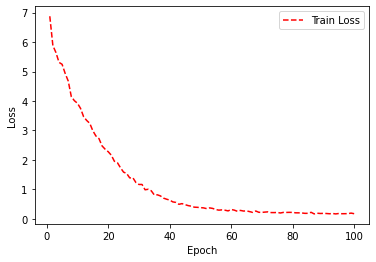

In [170]:
epoch_count = range(1, len(loss_history) + 1) 

# Visualize loss history
plt.plot(epoch_count, loss_history, 'r--')
plt.legend(['Train Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### **More powerful cell!**

In the previous part, we implemented a simple Elman recurrent network. We can easily extend it to an **LSTM** by modifying our code slightly. Since we already learned how to implement the recurrent cell itself, in this part, we will simply use the existing pytorch `nn.LSTM` implementation. One major difference between these two networks is their **hidden state**. Unlike an Elman RNN which has only a single state, the hidden state of an LSTM is made up of two parts.
You can take a look at the online documentation of [`nn.LSTM`](https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM) as well as [`nn.LSTMCell`](https://pytorch.org/docs/stable/nn.html?highlight=lstmcell#torch.nn.LSTMCell)

<img src="https://www.knime.com/sites/default/files/fig_2_2.png" alt="img" width="512px"/>

Please fill in the forward function of the LSTM network.

In [171]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, n_tokens, hidden_sz):
        super(LSTMLanguageModel, self).__init__()
        self.hidden_size = hidden_sz
        
        self.embedding = nn.Embedding(n_tokens, hidden_sz)
        self.rnn = nn.LSTM(hidden_sz, hidden_sz, batch_first=True)
        self.decoder = nn.Linear(hidden_sz, n_tokens)
        
    def forward(self, x, prev_state):
        """
        :return: logits, state; where logits is output of the decoder,
                 and state is the final rnn state.
        """
        ############### for student ################
        x = self.embedding(x)
        x,_ = self.rnn(x, prev_state)
        logits = self.decoder(x)

        return logits, prev_state
        ############################################
    
    def zero_state(self, batch_size, dev):
        """
        look up the dimensions of the nn.LSTM state (which is a tuple!)
        return a zero-initialized state
        put on the correct device (dev)
        """
        return (torch.zeros(1, batch_size, self.hidden_size).to(dev),
                torch.zeros(1, batch_size, self.hidden_size).to(dev))
    

In [172]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

# Let's test the LSTM model
arr = torch.randint(n_token, [64, 32], dtype=torch.long).to(device)
model = LSTMLanguageModel(n_token, 256).to(device)
state = model.zero_state(64, device)
out, state = model(arr, state)

assert type(out) != type(None), 'Did you return output?'
assert type(state) != type(None), 'How about state?'
assert out.shape == torch.Size([64, 32, n_token]), out.shape
assert isinstance(state, tuple) 
print("LSTM is complete! Perfect!")

LSTM is complete! Perfect!


### **Evaluation method**

So far, we have only evaluated the performance of our neural networks throughout the training loop, only calculating the loss for a single mini-batch at a time. Now, we will create an evaluation method to evaluate the performance of our network across multiple batches. 

Complete the __evaluate()__ method below so that it returns the overall (mean) cross-entropy loss. 

In [173]:
def evaluate(device, net, n_token, batch_size, seq_size, x_test, y_test):
    
    net.eval()
    
    total_loss = 0.
    
    # intialize state
    zero_state = net.zero_state(batch_size, device)

    # batchify data
    batches = get_batches(x_test, y_test, batch_size, seq_size)

    # 1) loop through the batches
    ##   convert data to tensor and put it on the device
    ##   calculate forward path
    ##   use 'criterion' (as defined earlier in the training loop) to calculate the loss for each mini-batch (reshape might be needed)
    ##   add mini-batch loss to total_loss
    # 2) return average loss
    ############### for student ################
    count = 0

    for x, y in batches:

            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)

            logits, state = net(x, zero_state)

            logits = logits.view(-1, n_token)      #Should be tensor of unnormalized logits with shape (N,C)
            y = y.view(-1)        #Should be tensor of class indices with shape N
            loss = criterion(logits,y)    
            #print("Loss=" + str(loss.item()))
            total_loss += loss.item()
            count += 1
    
    #print(total_loss/len(list(b)))
    return total_loss/ count
    ############################################

In [174]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

id_to_token, token_to_id, n_token, inp_text, out_text = get_data_lm(dummy_text)
net = LSTMLanguageModel(n_token, 256).to(device)
dummy_loss = evaluate(device, net, n_token, 10, 64, inp_text, out_text)

assert np.exp(dummy_loss) < 1e4, 'your dummy loss is too large!'

print("It looks alright.")

It looks alright.


### Train the LSTM

Let's train the LSTM on a small amount of dummy text:

In [175]:
id_to_token, token_to_id, n_token, inp_text, out_text = get_data_lm(dummy_text)
X_train, X_test, y_train, y_test = train_test_split(inp_text, out_text, test_size=0.25, random_state=SEED)

Modify the training loop you defined for the elman RNN, and use it to train the LSTM model:

In [176]:
net = LSTMLanguageModel(n_token, hidden_size)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

iteration = 0
total_epochs = 150

train_loss = 0
train_history = []
valid_history = []


for e in range(total_epochs):
    
    batches = get_batches(X_train, y_train, batch_size, seq_size)
    
    
    # 1) set the initial state (to zero, as mentioned)
    # 2) loop through the data and train the model
    #     (See RNNLanguage model for the logic)
    
    ############### for student ################
    state_h = net.zero_state(batch_size, device)
    #state_h = state_h.to(device)
    
    for x, y in batches:

        x = torch.tensor(x).to(device)
        y = torch.tensor(y).to(device)

        #net.train()
        optimizer.zero_grad()
        logits, state = net(x, state_h) 
        logits = logits.view(-1, n_token)      #Should be tensor of unnormalized logits with shape (N,C)
        y = y.view(-1)        #Should be tensor of class indices with shape N
        train_loss = criterion(logits,y)    
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1)    # Technique for preventing gradients of becoming too large. It reescale gradients if norm exeedes specified value
        optimizer.step()
    ############################################
        
        if iteration % 50 == 0:
            train_loss = train_loss / 50.0   
            val_loss = evaluate(device, net, n_token, 10, seq_size, X_test, y_test)
            
            train_history.append(train_loss.item()) #Edited
            valid_history.append(val_loss)
            
            print('epoch: {}/{} iteration: {} train-Loss: {} val-loss: {}'.format(e, total_epochs, iteration, train_loss, val_loss))
            train_loss = 0

        iteration += 1    #Added

epoch: 0/150 iteration: 0 train-Loss: 0.157963365316391 val-loss: 7.879390580313546
epoch: 3/150 iteration: 50 train-Loss: 0.12123798578977585 val-loss: 6.425015449523926
epoch: 7/150 iteration: 100 train-Loss: 0.10865218192338943 val-loss: 6.115164007459368
epoch: 11/150 iteration: 150 train-Loss: 0.09686136245727539 val-loss: 5.996698720114572
epoch: 15/150 iteration: 200 train-Loss: 0.0847039446234703 val-loss: 5.924455574580601
epoch: 19/150 iteration: 250 train-Loss: 0.07996469736099243 val-loss: 5.9420198031834195
epoch: 23/150 iteration: 300 train-Loss: 0.07339205592870712 val-loss: 5.961230005536761
epoch: 26/150 iteration: 350 train-Loss: 0.06698905676603317 val-loss: 6.015736239297049
epoch: 30/150 iteration: 400 train-Loss: 0.060556888580322266 val-loss: 6.140336309160505
epoch: 34/150 iteration: 450 train-Loss: 0.053081318736076355 val-loss: 6.143681526184082
epoch: 38/150 iteration: 500 train-Loss: 0.04835304245352745 val-loss: 6.237736974443708
epoch: 42/150 iteration: 55

In [177]:
## evaluation
## DON'T CHANGE THIS CELL IN ANY WAY

dummy_loss = evaluate(device, net, n_token, 10, 64, X_test, y_test)

assert np.exp(dummy_loss) < 1e4, 'your dummy loss is too large!'

print("Good job! We're almost done..")

Good job! We're almost done..


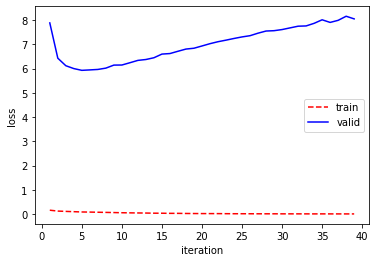

In [178]:
epoch_count = range(1, len(train_history) + 1) 

# Visualize loss history
plt.plot(epoch_count, train_history, 'r--')
plt.plot(epoch_count, valid_history, 'b-')
plt.legend(['train', 'valid'])
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

What we see on the plot above is known as __overfitting__: the training loss becomes really small towards the end of training, but the validation error of the model is high. This is due to the model learning “too much” from the training dataset, so that it does not generalize well to unseen data. You can probably guess why this happened? We are still training the model on a small subsample of the data (`dummy_text`)! If you train the model on the whole dataset, you will definitely get better validation scores. You can try this out if you want to, but be aware that training will likely take much longer. 

### Question 6

Give at least 6 ideas on how you could make your neural language model better (short, bullet-style answers). (You can find inspiration online, for example here: https://arxiv.org/pdf/1708.02182.pdf) 

**<font color=blue><<< INSERT ANSWER HERE >>></font>**
- Wheight Regularization: L1 or L2 regularization. 
- Wheighted Dropout LSTM: Like Dropout, but instead of dropping individual neurons, drops individual wheights.
- Early Stopping: Stop training when performance on validation is not improving, to model does not overfit on data.
- Batch Normalization: Normalizes the inputs to each layer of the network to have zero mean and unit variance.
- Skip Connections: Connect hidden states of layers at diferent time steps.arXiv:1610.03167 [cs.CL]
- Using more advanced architectures: multiplicative LSTM arXiv:1609.07959 [cs.NE] and LSTM with an attention mechanism.

**If you would have a lot more time (not within the scope of this lab!)**: you've learned the building blocks of neural language models, you can now build the ultimate monster:
* Weight tying: Two weight matrices have been used for input or output respectively (https://arxiv.org/abs/1608.05859)
* Make it character-level or make use of sub-word units like [bpe](https://en.wikipedia.org/wiki/Byte_pair_encoding);
* Use both character-level and word-level features to train a word-level language model
* ...

### Question 7

Please give us a rough estimation of the hours you invested to complete this session. This will not affect your grade ;) However, it might help us with the design of our future lab sessions. 
 
**<font color=blue><<< INSERT ANSWER HERE >>></font>**
- First Part: ±4 hours, Second Part: ±6 hours, In total: ±10 hours

## Acknowledgment
If you received help or feedback from fellow students, or from any large language model, please acknowledge that here. We count on your academic honesty:

**<font color=blue><<< INSERT ANSWER HERE >>></font>**
- Used Bing AI for code troubleshooting and explanaitions of pytorch documentation. 
Examples: 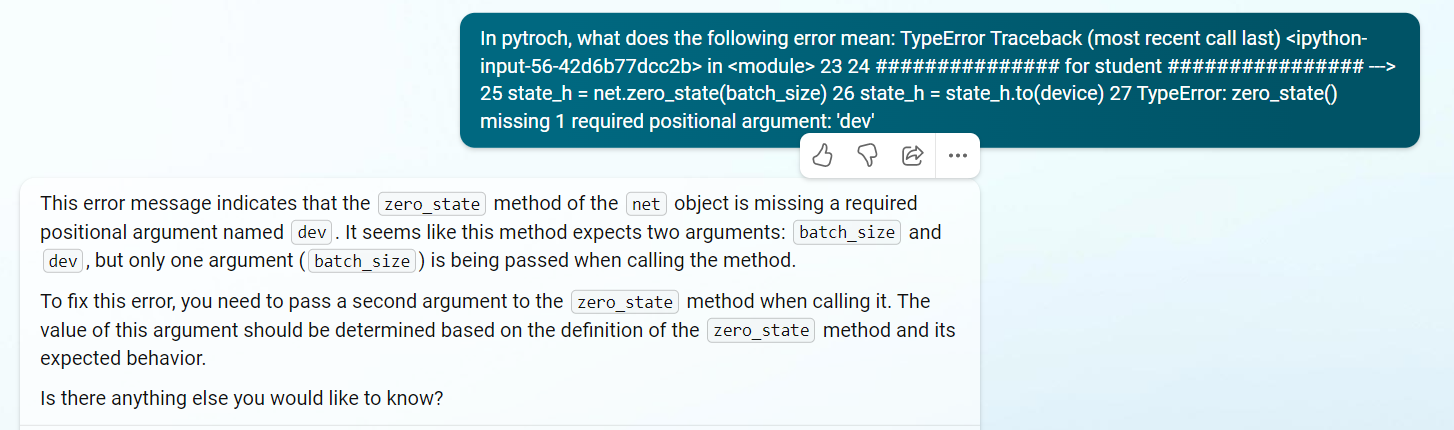
